In [2]:
#purpose: follow a leader trajectory as closely as possible without hitting
#discrete behaviors: accelerate (-1), constant speed(0), decelerate(1)
import numpy as np
import matplotlib.pyplot as plt

episode:0 episodeReward(avg):-6.243860860156597


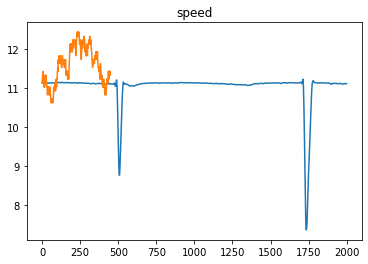

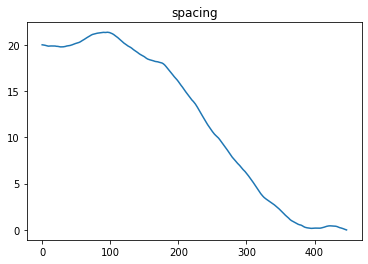

episode:500 episodeReward(avg):-0.45378114227630784


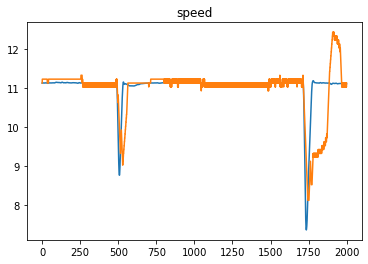

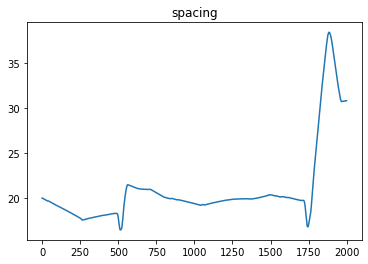

episode:1000 episodeReward(avg):-0.279367885647986


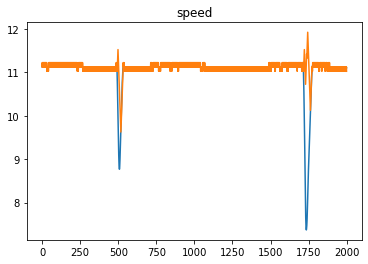

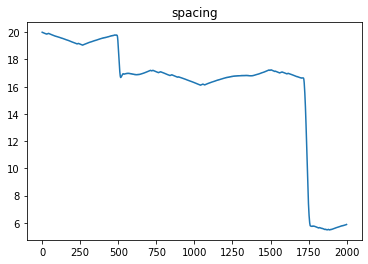

episode:1500 episodeReward(avg):-0.279367885647986


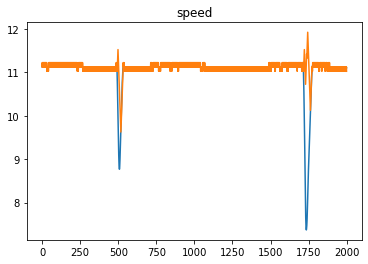

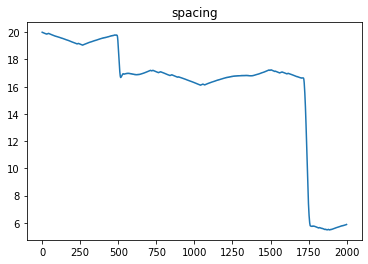

episode:2000 episodeReward(avg):-0.279367885647986


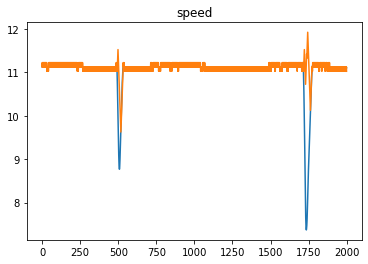

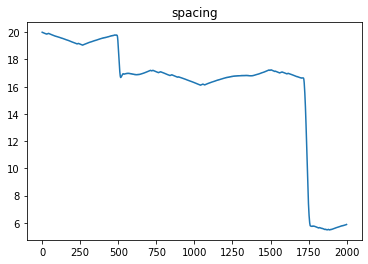

episode:2500 episodeReward(avg):-0.279367885647986


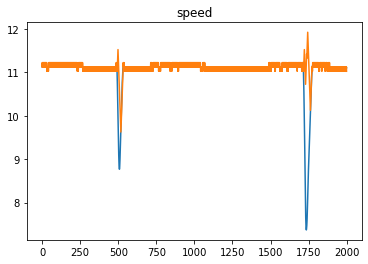

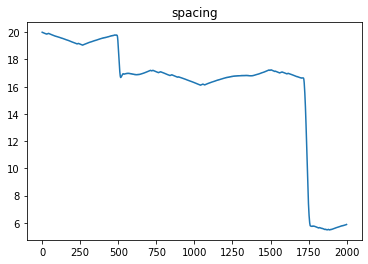

episode:3000 episodeReward(avg):-0.279367885647986


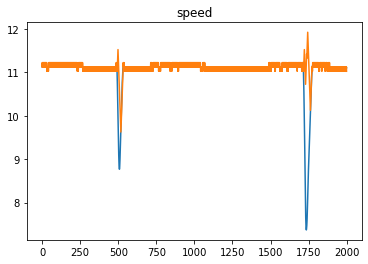

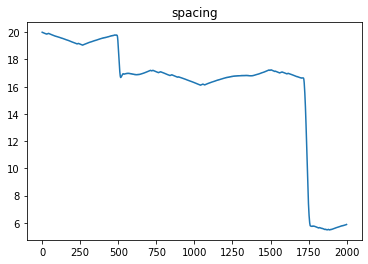

episode:3500 episodeReward(avg):-0.279367885647986


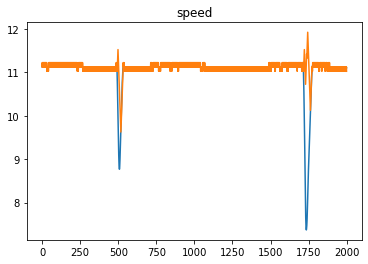

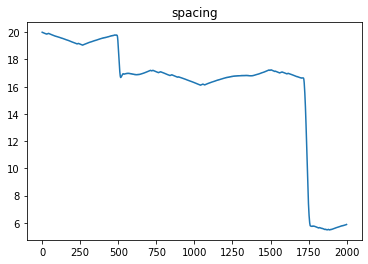

episode:4000 episodeReward(avg):-0.279367885647986


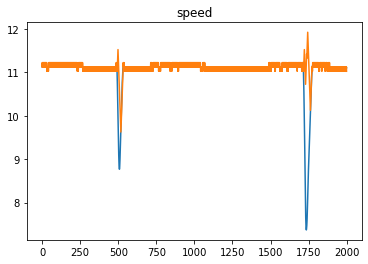

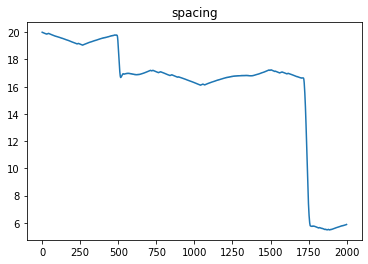

episode:4500 episodeReward(avg):-0.279367885647986


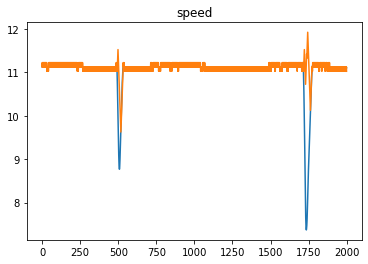

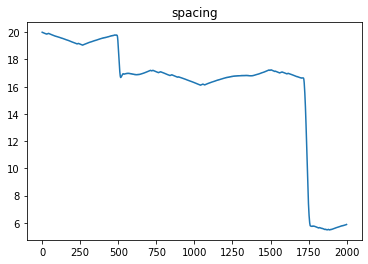

In [3]:
EPISODES = int(5e3)
HIT_PENALTY = -2500 #hit the leader
HEADWAY_PENALTY = -.01 #far from leader
SPEED_DIFF_PENALTY = -1 #large speed diff
TIME_REWARD = .01
SIM_RESOLUTION = .1

epsilon = .9
EPS_DECAY = .99

SHOW_EVERY = 500

LEARNING_RATE = .9
DISCOUNT = .95

class vehicle:
    def __init__(self, speed, loc):
        self.location = loc
        self.speed = speed
    def action_a(self, aRate):
        self.speed = self.speed - aRate * SIM_RESOLUTION
        self.location = self.location + self.speed * SIM_RESOLUTION
    def action_v(self, speed):
        self.speed = speed
        self.location = self.location + speed * SIM_RESOLUTION
    def update(self, speed, loc):
        self.location = loc
        self.speed = speed 

def choice_to_a_rate(choice):
    return choice - 1
        
Q_TABLE_SIZE = [20] * 3 #spacing, leader speed, speed diff
def discretize_status(status):
    sRange = [(-40, 0), (0, 20), (-20, 20)]
    interval = [(sRange[i][1] - sRange[i][0]) / Q_TABLE_SIZE[i] for i in range(len(sRange))]
    discreteStatus = []
    for i, x in enumerate(status):
        if x <= sRange[i][0]:
            discreteStatus.append(0)
        elif x >= sRange[i][1]:
            discreteStatus.append(Q_TABLE_SIZE[i] - 1)
        else:
            discreteStatus.append(int((x - sRange[i][0]) // interval[i]))
    return tuple(discreteStatus)

qTable = np.random.uniform(low = -5, high = 0, size = (Q_TABLE_SIZE + [3]))


epRewards = []
leadSpeedProfile = np.genfromtxt('test_leader.csv', delimiter=',')

for episode in range(EPISODES):
    if episode % SHOW_EVERY == 0:
        show = True
        followerSpeedProfile = [leadSpeedProfile[0]]
        leaderLoc = [0]
        followerLoc = [-20]
    else:
        show = False
    follower = vehicle(leadSpeedProfile[0], -20)
    leader = vehicle(leadSpeedProfile[0], 0)
    episodeReward = 0
    for t in range(1, len(leadSpeedProfile)):
        #current obs
        spacing = leader.location - follower.location
        leadSpeed = leader.speed
        speedDiff = leader.speed - follower.speed
        discretedStatus = discretize_status([spacing, leadSpeed, speedDiff])
        #make move
        if np.random.random() > epsilon:
            actChoice = np.argmax(qTable[discretedStatus])
        else:
            actChoice = np.random.randint(0, 3)
        follower.action_a(choice_to_a_rate(actChoice))
        leader.action_v(leadSpeedProfile[t])
        
        #reward
        newSpacing = leader.location - follower.location
        newSpeedDiff = leader.speed - follower.speed
        if newSpacing < 0:
            reward = HIT_PENALTY 
        else:
            reward = HEADWAY_PENALTY * newSpacing
            reward += SPEED_DIFF_PENALTY * abs(newSpeedDiff)
#             reward += TIME_REWARD * t
        
        #update q table
        newDiscretedStatus = discretize_status([newSpacing, 
                                                leader.speed, 
                                                newSpeedDiff])
        if show:
            followerSpeedProfile.append(follower.speed)
            followerLoc.append(follower.location)
            leaderLoc.append(leader.location)

        maxFutureQ = np.max(qTable[newDiscretedStatus])
        currentQ = qTable[discretedStatus][actChoice]
        if newSpacing < 0:
            newQ = HIT_PENALTY
        else:
            newQ = (1 - LEARNING_RATE) * currentQ + LEARNING_RATE * (reward + DISCOUNT * maxFutureQ)
        qTable[discretedStatus][actChoice] = newQ
        
        episodeReward += reward
        if newSpacing < 0:
            break
    
    if show:
        print(f"episode:{episode} episodeReward(avg):{episodeReward/t}")
        plt.figure()
        plt.plot(leadSpeedProfile)
        plt.plot(followerSpeedProfile)
        plt.title('speed')
        plt.figure()
        plt.plot(np.array(leaderLoc) - np.array(followerLoc))
        plt.title('spacing')
        plt.show()
        
    epRewards.append(episodeReward)
    epsilon *= EPS_DECAY
        
        
        
        
        
        



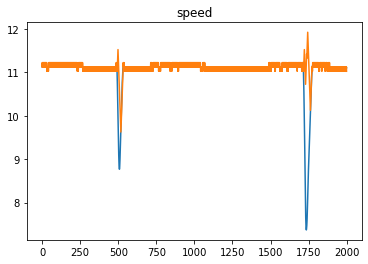

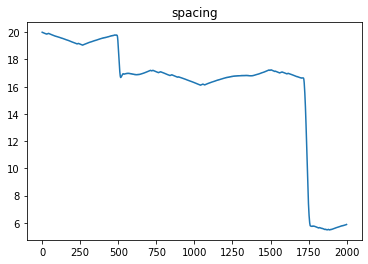

In [6]:
#final q_table
leadSpeedProfile = np.genfromtxt('test_leader.csv', delimiter=',')
followerSpeedProfile = [leadSpeedProfile[0]]
leaderLoc = [0]
followerLoc = [-20]
follower = vehicle(leadSpeedProfile[0], -20)
leader = vehicle(leadSpeedProfile[0], 0)
for t in range(1, len(leadSpeedProfile)):
    #current obs
    spacing = leader.location - follower.location
    leadSpeed = leader.speed
    speedDiff = leader.speed - follower.speed
    discretedStatus = discretize_status([spacing, leadSpeed, speedDiff])
    #make move
    if np.random.random() > epsilon:
        actChoice = np.argmax(qTable[discretedStatus])
    else:
        actChoice = np.random.randint(0, 3)
    follower.action_a(choice_to_a_rate(actChoice))
    leader.action_v(leadSpeedProfile[t])

    followerSpeedProfile.append(follower.speed)
    followerLoc.append(follower.location)
    leaderLoc.append(leader.location)
plt.figure()
plt.plot(leadSpeedProfile)
plt.plot(followerSpeedProfile)
plt.title('speed')
plt.figure()
plt.plot(np.array(leaderLoc) - np.array(followerLoc))
plt.title('spacing')
plt.show()

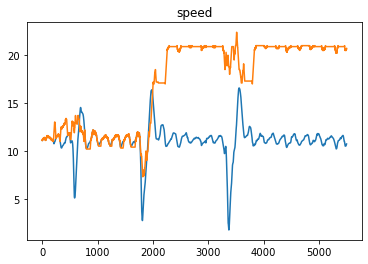

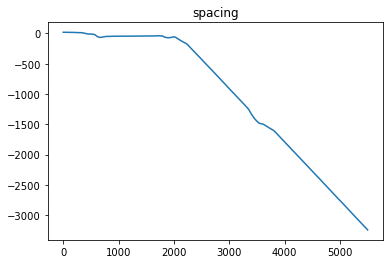

In [7]:
#final q_table
leadSpeedProfile = np.genfromtxt('test_leader_2.csv', delimiter=',')
followerSpeedProfile = [leadSpeedProfile[0]]
leaderLoc = [0]
followerLoc = [-20]
follower = vehicle(leadSpeedProfile[0], -20)
leader = vehicle(leadSpeedProfile[0], 0)
for t in range(1, len(leadSpeedProfile)):
    #current obs
    spacing = leader.location - follower.location
    leadSpeed = leader.speed
    speedDiff = leader.speed - follower.speed
    discretedStatus = discretize_status([spacing, leadSpeed, speedDiff])
    #make move
    if np.random.random() > epsilon:
        actChoice = np.argmax(qTable[discretedStatus])
    else:
        actChoice = np.random.randint(0, 3)
    follower.action_a(choice_to_a_rate(actChoice))
    leader.action_v(leadSpeedProfile[t])

    followerSpeedProfile.append(follower.speed)
    followerLoc.append(follower.location)
    leaderLoc.append(leader.location)
plt.figure()
plt.plot(leadSpeedProfile)
plt.plot(followerSpeedProfile)
plt.title('speed')
plt.figure()
plt.plot(np.array(leaderLoc) - np.array(followerLoc))
plt.title('spacing')
plt.show()